<a href="https://colab.research.google.com/github/taareek/machine_learning/blob/main/prac_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing our dataset

In [3]:
import torchvision
import torch
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Geting our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ls

drive/  sample_data/


In [6]:
train_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Alzheimers-ADNI/train"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Alzheimers-ADNI/test"

Shape of this image:  (256, 256, 3)


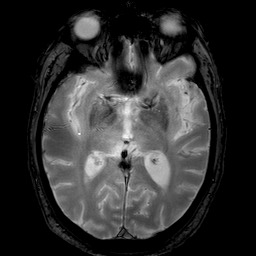

In [7]:
a = "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Alzheimers-ADNI/test/Final AD JPEG/ADNI_002_S_4521_MR_Axial_T2-Star__br_raw_20160324122521837_22_S402609_I662501.jpg"
import cv2
img = cv2.imread(a)
print("Shape of this image: ",img.shape)
from google.colab.patches import cv2_imshow
cv2_imshow(img)
#cv2.imshow('pic ari',img)


In [8]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.0238]

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                                       ])

test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                                       ])

In [9]:
train_set = torchvision.datasets.ImageFolder(root= train_dataset_path, transform= train_transforms)
test_set = torchvision.datasets.ImageFolder(root= test_dataset_path, transform= test_transforms)

In [10]:
def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size= 6, shuffle= True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow= 3)
  plt.imshow(np.transpose(grid, (1,2,0)))
  print("labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 0, 4, 4])


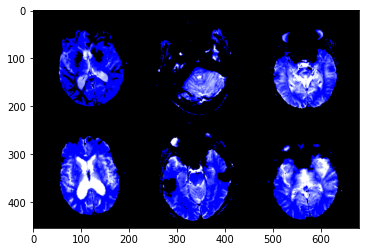

In [11]:
show_transformed_images(train_set)

In [12]:
print(len(train_set))
print(len(test_set))

1101
195


# Visualizing our Dataset

In [13]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns

splitting data into train, validation, test

In [14]:
valid_size= 0.2 # taking 20% data as out validation set
num_train = len(train_set)
indices = list(range(num_train))
print('Total number of our train data: ',len(indices))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
#print(split)
train_idx, valid_idx = indices[split:], indices[:split]
print('After splitting train data: ',len(train_idx))
print('After splitting validation data: ',len(valid_idx))

Total number of our train data:  1101
After splitting train data:  881
After splitting validation data:  220


In [15]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
# image classes
classes = ['AD', 'CN', 'EMCI', 'LMCI', 'MCI']

In [16]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

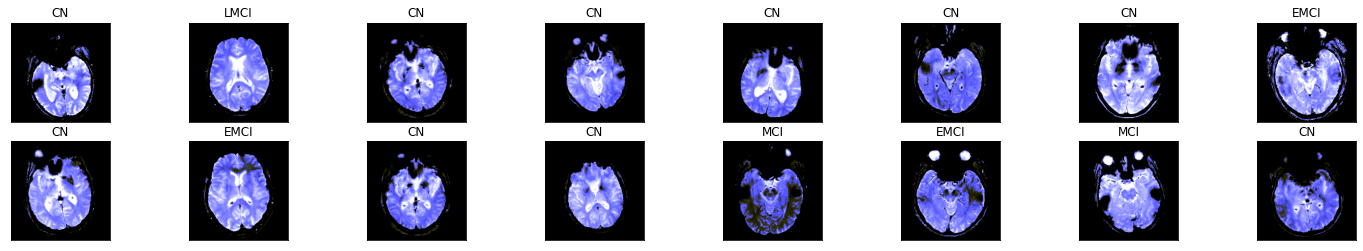

In [17]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Training our Data with VGG16 Model

In [49]:
# Taking vgg16 model 
from torchvision import models
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [50]:
# change the number of classes  
# We have taken 5 output features as we have 5 classes images 
vgg16.classifier[6].out_features = 5
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

In [51]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [52]:
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [53]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay= 5e-4)
# loss function
criterion = nn.CrossEntropyLoss()

In [54]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    vgg16.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg16.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = vgg16(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), 'model_alzheimer.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.767491 	Validation Loss: 1.888291
Validation loss decreased (inf --> 1.888291).  Saving model ...
Epoch: 2 	Training Loss: 2.105853 	Validation Loss: 1.792563
Validation loss decreased (1.888291 --> 1.792563).  Saving model ...
Epoch: 3 	Training Loss: 1.766243 	Validation Loss: 1.622853
Validation loss decreased (1.792563 --> 1.622853).  Saving model ...
Epoch: 4 	Training Loss: 1.555758 	Validation Loss: 1.476899
Validation loss decreased (1.622853 --> 1.476899).  Saving model ...
Epoch: 5 	Training Loss: 1.619185 	Validation Loss: 1.400235
Validation loss decreased (1.476899 --> 1.400235).  Saving model ...
Epoch: 6 	Training Loss: 1.514039 	Validation Loss: 1.580812
Epoch: 7 	Training Loss: 1.594169 	Validation Loss: 1.399569
Validation loss decreased (1.400235 --> 1.399569).  Saving model ...
Epoch: 8 	Training Loss: 1.467749 	Validation Loss: 1.603106
Epoch: 9 	Training Loss: 1.549598 	Validation Loss: 1.391028
Validation loss decreased (1.399569 --> 1.

In [55]:
vgg16.load_state_dict(torch.load('model_alzheimer.pt'))

<All keys matched successfully>

In [79]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

In [80]:
for data, target in test_loader:
  print(target)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
tensor([4, 4, 4])


In [85]:
n_corrects= 0
n_samples= 0

#vgg16.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    _, pred = torch.max(output, 1)    
    n_corrects += (pred== target).sum().item()
    n_samples += target.size(0)

print(f'Overall accuracy {(n_corrects / n_samples)*100}%')

Overall accuracy 45.12820512820513%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

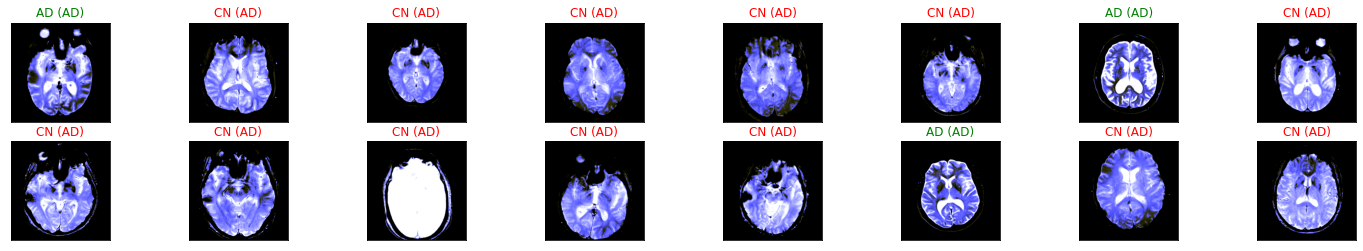

In [87]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [89]:
print(len(test_set))
print(len(test_set.targets))

195
195


In [113]:
@torch.no_grad()
def prediction(cnn, batch_loader):
  total_preds = torch.tensor([]).cuda()
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    #print(len(output))
    # convert output probabilities to predicted class
    _,pred = torch.max(output, 1) 
    #print(pred)
    total_preds = torch.cat(
            (total_preds, output)
            ,dim=0
        )
  return total_preds

In [91]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [116]:
with torch.no_grad():
    test_prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=16)
    test_preds = prediction(vgg16, test_prediction_loader)

In [117]:
print(len(test_preds))
#test_preds

195


Confusion matrix, without normalization


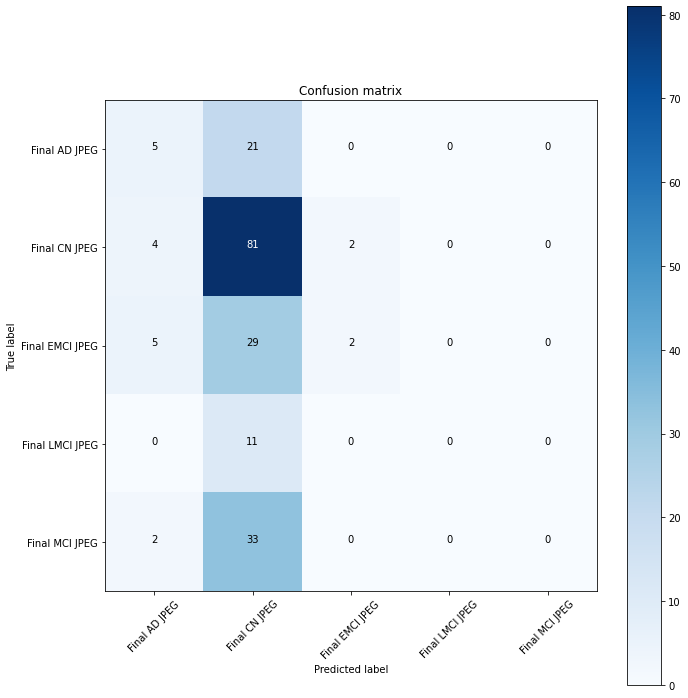

In [118]:
test_preds = test_preds.cpu()
conf_matrix = confusion_matrix(test_set.targets, test_preds.argmax(dim= 1))
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix, train_set.classes)

In [101]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1